In [1]:
# libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import torch
from transformers import XLNetConfig, XLNetForTokenClassification, TrainingArguments
import random
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.functional import pearson_corrcoef
from torchmetrics import Metric
import os
import shutil
from ipynb.fs.full.utils_dh import RegressionTrainerMAE, RegressionTrainerPCC, RegressionTrainerTwoMAEPCC, RegressionTrainerTwoNormMAE, RiboDatasetGWS, GWSDatasetFromPandas, CorrCoef, collate_fn, compute_metrics, compute_metrics_saved  # custom dataset and trainer
from ipynb.fs.full.prediction_utils import analyse_dh_outputs, quantile_metric, attention_maps
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-10 17:30:39.900458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 17:30:42.259772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# dataset paths 
data_folder = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Darnell_Full/Darnell/data_conds_split/processed/'

# model parameters
annot_thresh = 0.5
longZerosThresh_val = 20
percNansThresh_val = 0.05
d_model_val = 256
n_layers_val = 3
n_heads_val = 8
dropout_val = 0.3
lr_val = 1e-4
batch_size_val = 1
loss_fun_name = '3LMAE' # either 3LMAE or 3LPCC
alpha = 1 # alpha value for the deprivation difference loss term

# model name and output folder path
model_name = 'XLNetDepr-' + str(n_layers_val) + '_' + str(d_model_val) + '_' + str(n_heads_val) + '-ALL_NA-PEL-BS' + str(batch_size_val) + '-GWS_PCC_IT192_DH_' + str(loss_fun_name) + 'ALPHA' + str(alpha) + '_NZ' + str(longZerosThresh_val) + '_PNTh' + str(percNansThresh_val) + '_AnnotThresh' + str(annot_thresh)
output_loc = "saved_models/" + model_name

# load xlnet to train from scratch
config = XLNetConfig(vocab_size=193, pad_token_id=192, d_model = d_model_val, n_layer = n_layers_val, n_head = n_heads_val, d_inner = d_model_val, num_labels = 1, dropout=dropout_val) # 5^3 + 1 for padding
model = XLNetForTokenClassification(config)

# modify the output layer
model.classifier = torch.nn.Linear(d_model_val, 2, bias=True)

In [3]:
# generate dataset
ds = 'ALL' # uses all the three conditions
train_dataset, test_dataset = RiboDatasetGWS(data_folder, ds, threshold = annot_thresh, longZerosThresh = longZerosThresh_val, percNansThresh = percNansThresh_val)

# convert pandas dataframes into torch datasets
train_dataset = GWSDatasetFromPandas(train_dataset)
test_dataset = GWSDatasetFromPandas(test_dataset)
print("samples in train dataset: ", len(train_dataset))
print("samples in test dataset: ", len(test_dataset))

samples in train dataset:  6386
samples in test dataset:  1592


In [4]:
# xlnet training arguments
training_args = TrainingArguments(
    output_dir = output_loc,
    learning_rate = lr_val,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = batch_size_val, # training batch size = per_device_train_batch_size * gradient_accumulation_steps
    per_device_eval_batch_size = 1,
    eval_accumulation_steps = 4, 
    num_train_epochs = 200,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = False,
    dataloader_pin_memory = True,
    save_total_limit = 5,
    dataloader_num_workers = 4,
    include_inputs_for_metrics = True
)

# initialize trainer
if loss_fun_name == '3LMAE':
    trainer = RegressionTrainerMAE(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_saved,
        alpha = alpha
    )
elif loss_fun_name == '3LPCC':
    trainer = RegressionTrainerPCC(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_saved,
        alpha = alpha
    )
elif loss_fun_name == '2LDPCCCMAE':
    trainer = RegressionTrainerTwoMAEPCC(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_saved,
        alpha = alpha
    )
elif loss_fun_name == '2LNormMAE':
    trainer = RegressionTrainerTwoNormMAE(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_saved,
        alpha = alpha
    )

In [5]:
# load model best weights
model.load_state_dict(torch.load(output_loc + "/best_model/pytorch_model.bin"))

<All keys matched successfully>

In [ ]:
# evaluate on test set
trainer.evaluate()

In [6]:
# load preds
# make directory
dir = "preds/" + model_name
if not os.path.exists(dir):
    os.makedirs(dir)

dir = "preds/" + model_name + "/analysis_dh"
if not os.path.exists(dir):
    os.makedirs(dir)

dir = "preds/" + model_name + "/analysis_dh/full_plots"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)
    os.makedirs(dir)

dir = "preds/" + model_name + "/analysis_dh/quantile_metric_plots"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)
    os.makedirs(dir)

dir = "preds/" + model_name + "/analysis_dh/condition_dists"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)
    os.makedirs(dir)

dir = "preds/" + model_name + "/analysis_dh/attn_plots"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)
    os.makedirs(dir)

# move the preds to the directory
os.system("mv -f " + "preds/preds.npy preds/" + model_name + "/preds.npy")
os.system("mv -f " + "preds/labels.npy preds/" + model_name + "/labels.npy")
os.system("mv -f " + "preds/inputs.npy preds/" + model_name + "/inputs.npy")

preds = np.load("preds/" + model_name + "/preds.npy")
labels = np.load("preds/" + model_name + "/labels.npy")
inputs = np.load("preds/" + model_name + "/inputs.npy")

mv: cannot stat 'preds/preds.npy': No such file or directory
mv: cannot stat 'preds/labels.npy': No such file or directory
mv: cannot stat 'preds/inputs.npy': No such file or directory


In [ ]:
# generates plots for the best 10 and worst 10 predictions
# saves all these plots in the "preds/model_name/analysis_dh/full_plots" directory
analyse_dh_outputs(preds, labels, inputs, "preds/" + model_name + "/analysis_dh", 'data/dh/ribo_test_ALL-NA_dh_' + str(annot_thresh) + '_NZ_' + str(longZerosThresh_val) + '_PercNan_' + str(percNansThresh_val) + '.csv')

In [ ]:
quantile_metric(preds, labels, inputs, "preds/" + model_name + "/analysis_dh/quantile_metric_plots/", 'data/dh/ribo_test_ALL-NA_dh_' + str(annot_thresh) + '_NZ_' + str(longZerosThresh_val) + '_PercNan_' + str(percNansThresh_val) + '.csv')

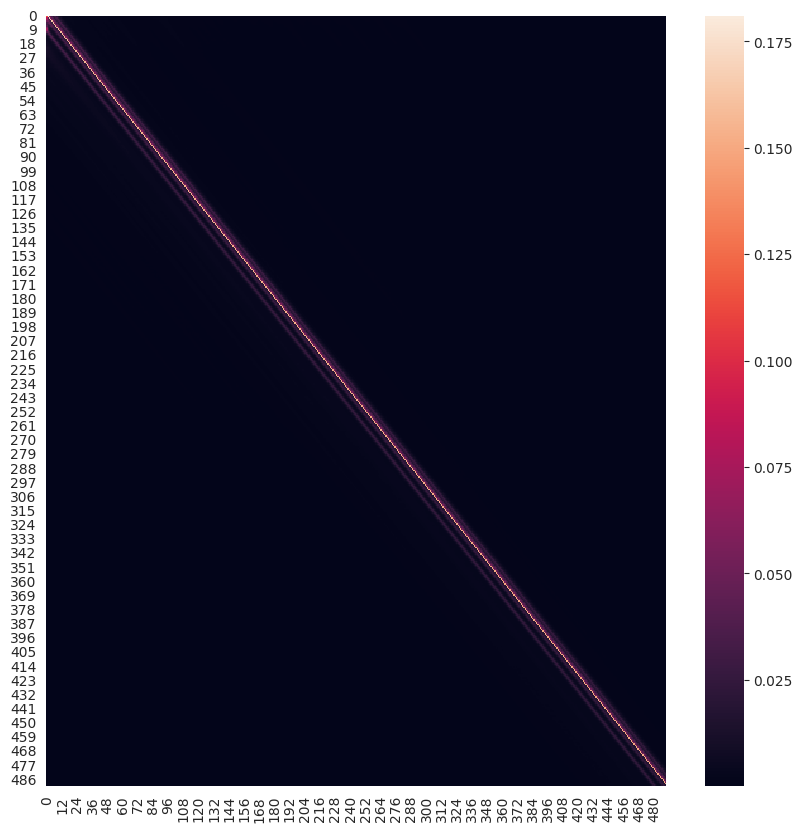

<Figure size 640x480 with 0 Axes>

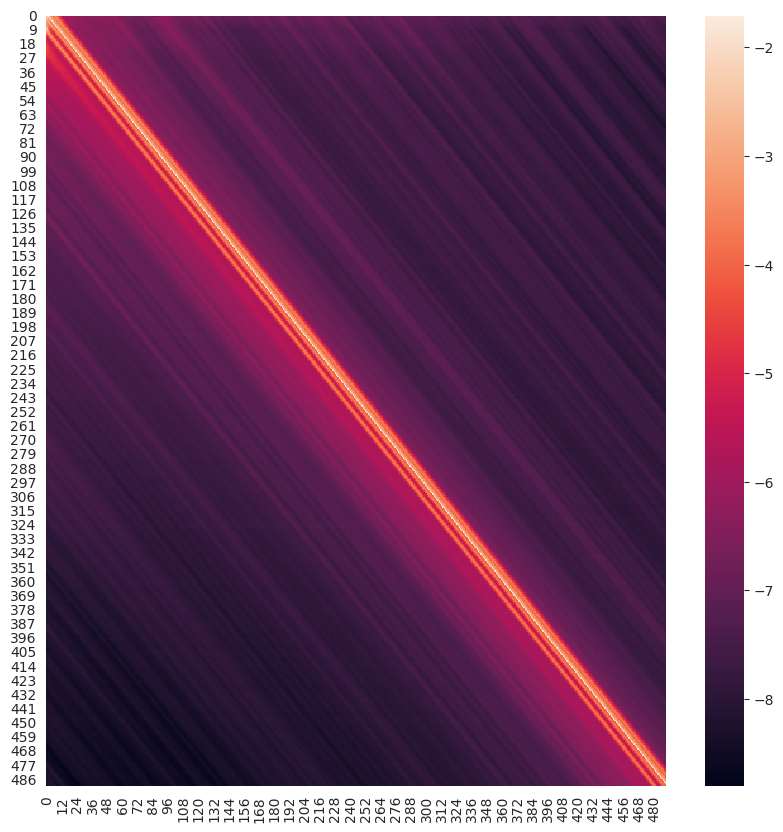

Number of important codons to the left (avg):  8.514285714285714
Number of important codons to the right (avg):  8.93265306122449


<Figure size 640x480 with 0 Axes>

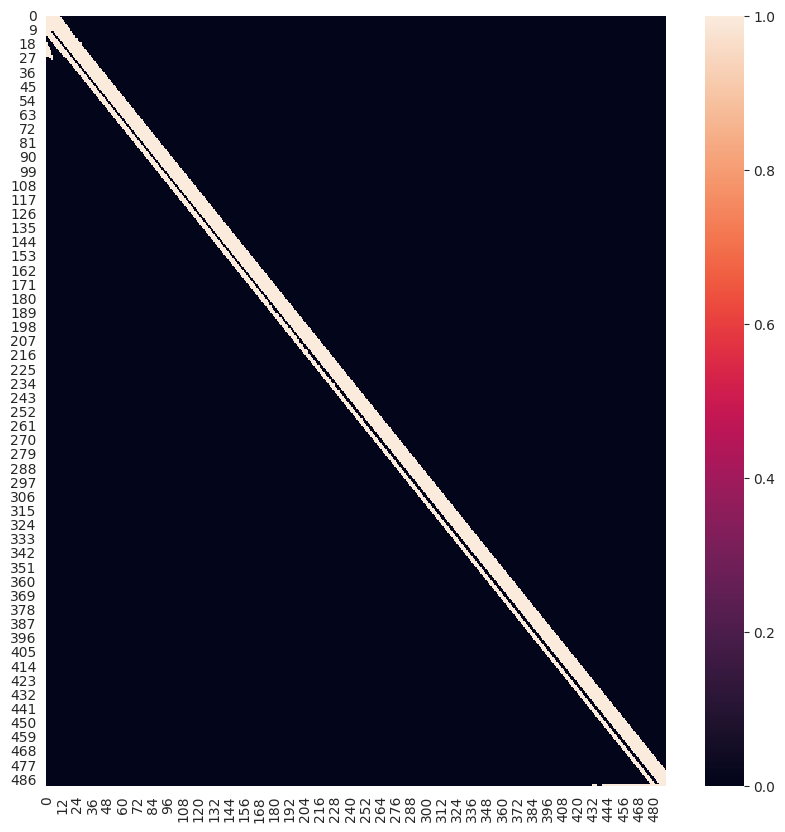

<Figure size 640x480 with 0 Axes>

In [7]:
attention_maps(model, test_dataset, "preds/" + model_name + "/analysis_dh/attn_plots/")